In [ ]:
import time, json, glob, os, itertools

import pandas as pd
import numpy as np

from py2neo import Graph, Node, Relationship
from tqdm.autonotebook import tqdm
from __future__ import print_function

from sklearn.datasets import fetch_mldata
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import matplotlib as mpl
import seaborn as sns
sns.set(rc={'figure.figsize':(12,8)})
mpl.style.use('seaborn-muted')
sns.set(style='whitegrid')

In [131]:
graph = Graph("bolt://matlaber5.media.mit.edu:7687", auth=('neo4j','myneo'))

n_nodes = len(graph.nodes)
n_edges = len(graph.relationships)
print("Connected to graph with {:,} nodes and {:,} edges!".format(n_nodes, n_edges))

def run_query(query, graph, print_query=False, run_query=True, 
              print_only=False, to_df=False, verbose=True):
    df = 1
    if print_only: 
        print_query = True
        run_query = False
    start_time = time.time()
    if print_query:
        print(query)
    if run_query:
        if to_df:
            df = graph.run(query).to_data_frame()
        else:
            graph.run(query)
    end_time = time.time()
    minutes_elapsed = (end_time-start_time)/60
    if verbose:
        print("Query completed in {:.2f} minutes.".format(minutes_elapsed))
    return df

Connected to graph with 278,076,495 nodes and 1,842,505,331 edges!


In [ ]:
nobel_winners_file = 'nobelwinners.csv'
nobel_winners = pd.read_csv(nobel_winners_file)

n_years_to_track = 15
citation_fun = lambda x: 'size((:Quanta {{{{year:q.year+{}}}}})-[:CITES]->(q)) as c{}'.format(x,x)
citation_str = ',\n'.join([citation_fun(i) for i in range(n_years_to_track)])
query_str = """
MATCH (a:Author)-[:AUTHORED]->(q:Quanta)
WHERE a.name="{}" AND q.year>{} AND q.year<{}
WITH q.title as title, q.year as year, size((:Quanta)-[:CITES]->(q)) as numCitations
WHERE numCitations>1000
RETURN title, year, numCitations,
""" + citation_str + "\nORDER BY numCitations DESC"

ndf = pd.DataFrame()

for i, row in tqdm(list(nobel_winners.iterrows())):
    if row['Laureate Type'] == 'Individual':
        
        year = row['Year']
        category = row['Category']
        name = row['Full Name']
        birth = row['Birth Date'][:4] if not pd.isna(row['Birth Date']) else np.nan 
        death = row['Death Date'][:4] if not pd.isna(row['Death Date']) else np.nan 
        print("{}: {} in {}...".format(year, name, category))
        
        query = query_str.format(name, 
                                 birth if not pd.isna(birth) else 1500, 
                                 death if not pd.isna(death) else 2019-n_years_to_track)
        df = run_query(query, graph, to_df=True, verbose=False, print_only=True)

        df['prizeCategory'] = category
        df['prizeYear'] = year
        df['prizeName'] = name
        df['prizeBirth'] = birth
        df['prizeDeath'] = death

        ndf = cdf.append(df, sort=False)
        
ndf.drop_duplicates(keep='first', inplace=True)
nobel_citations_file = 'nobelcitations.csv'
ndf.to_csv(nobel_citations_file)

In [482]:
ndf = pd.read_csv(nobel_citations_file)
print("Starting with {} papers... ".format(len(ndf)), end='')
min_year = 1900
min_citations = 500
mask = (ndf['prizeYear']>min_year) & (ndf['numCitations']>min_citations)
ndf = ndf.loc[mask,:].copy(deep=True)
print("Ending with {} papers...".format(len(ndf)))

Starting with 599 papers... Ending with 227 papers...


Text(0.5, 0.98, 'Citations per year for Nobel-winning papers for 15 years post-publication')

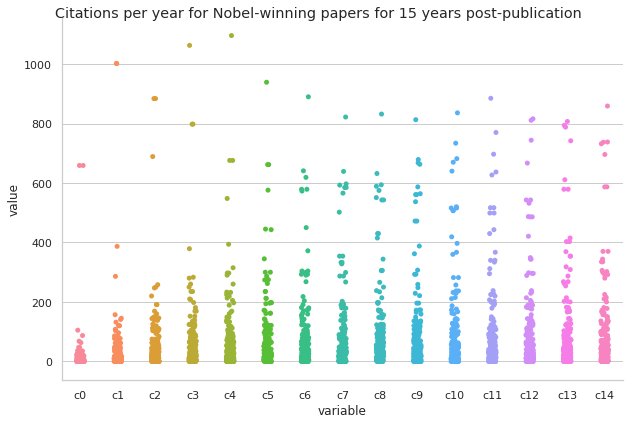

In [483]:
# Plot distribution of citation counts over time for Nobel publications
citation_columns = ['c{}'.format(i) for i in range(n_years_to_track)]
melted = ndf.melt(id_vars=['prizeYear'], value_vars=citation_columns)

g = sns.catplot(data=melted, x='variable', y='value', height=6, aspect=1.5)
title = "Citations per year for Nobel-winning papers for {} years post-publication".format(n_years_to_track)
g.fig.suptitle(title)

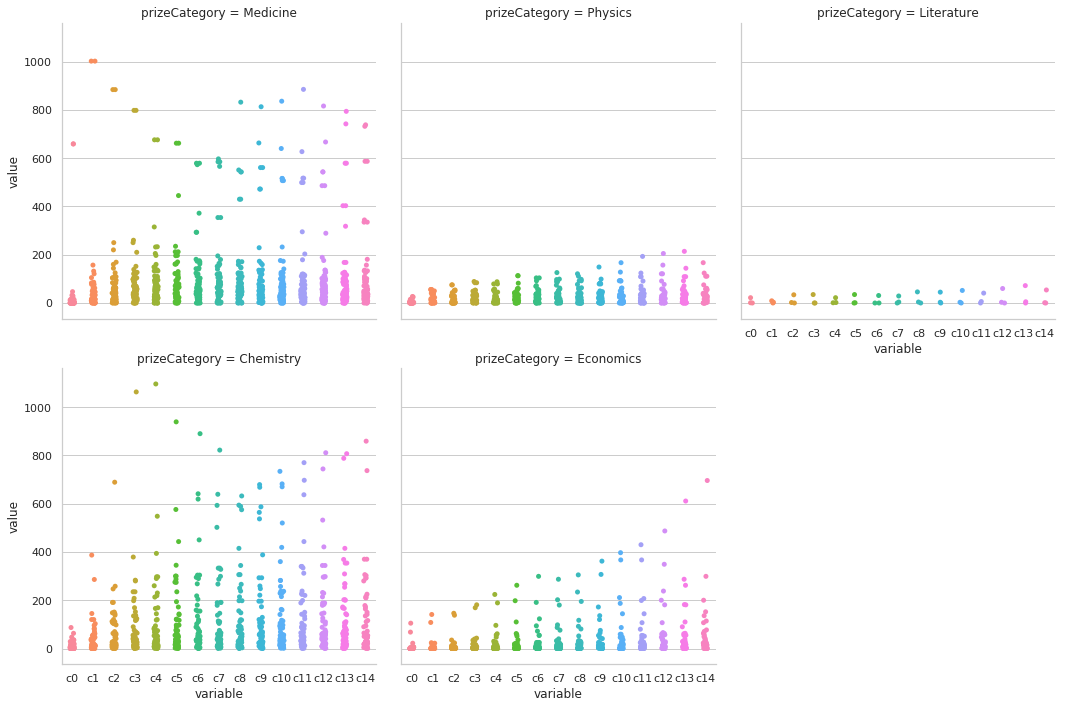

In [484]:
melted = ndf.melt(id_vars=['prizeCategory', 'prizeYear'], value_vars=citation_columns)
sns.catplot(data=melted, x='variable', y='value', col='prizeCategory', col_wrap=3)

In [485]:
# Import non-Nobel citation data
df = pd.read_csv('/tmp/data/result/top_citations_over_time.csv')
name_columns = ['title', 'id'] 

df = df[citation_columns + name_columns]
X = df[citation_columns].values

mask = (df['c6'] > df['c14']) & (df['c7'] > df['c14']) 
df['type'] = 'Venter-esque'
df.loc[~mask,'type'] = 'Botstein-esque'

df.head()

,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,c11,c12,c13,c14,title,id,type
0,1,21,114,281,487,779,1019,1215,1558,1881,2169,2473,2705,3081,3283,A rapid and sensitive method for the quantitat...,6e48427c-9d70-4d57-b3af-dc4f02330f7c,Botstein-esque
1,2170,2666,3393,3721,3788,3896,6456,6173,6951,7386,7361,6947,6297,6112,6152,Molecular cloning : a laboratory manual,a3aed21d-9e15-4a61-90df-fc39285bf7f3,Venter-esque
2,197,234,268,333,302,397,422,565,572,740,885,927,1099,1184,1453,Statistical power analysis for the behavioral ...,262ee906-bf66-4dec-bfba-90e89fa9303c,Botstein-esque
3,419,409,458,572,619,649,682,806,881,1034,1142,1393,1504,1710,2031,Standard methods for the examination of water ...,831ff9cf-6c77-415b-a5e1-a57b16bbb7d9,Botstein-esque
4,10,8,109,342,717,1207,1754,2342,2921,3566,4210,5203,5820,6483,6816,Analysis of relative gene expression data usin...,2701c2a9-b7cb-4a52-931f-05b17ee7afcf,Botstein-esque


	Explained variance of principal component 1: 85.90%
	Explained variance of principal component 2: 10.11%
	Explained variance of principal component 3: 1.94%


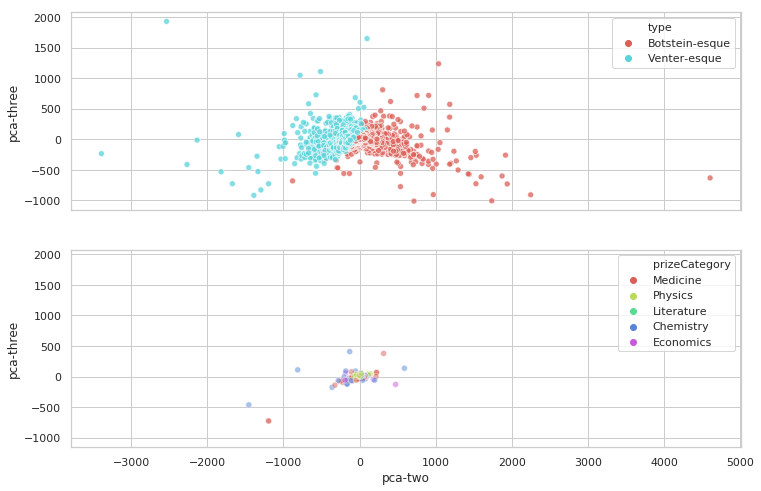

In [490]:
# PCA Analysis of Citation Patterns 
pca = PCA(n_components=3)
pca_result = pca.fit_transform(X)
df['pca-one'] = pca_result[:,0]
df['pca-two'] = pca_result[:,1] 
df['pca-three'] = pca_result[:,2]
for i in range(3):
    print('\tExplained variance of principal component {}: {:.2%}'.format(
        i+1, pca.explained_variance_ratio_[i]))

nobel_values = ndf[citation_columns].values
nobel_result = pca.transform(nobel_values)
ndf['pca-one'] = nobel_result[:,0]
ndf['pca-two'] = nobel_result[:,1] 
ndf['pca-three'] = nobel_result[:,2]

pcadf = ndf.loc[:,citation_columns + ['pca-one', 'pca-two', 'pca-three', 'prizeCategory']]
pcadf['type'] = 'Nobel'
pcadf = pcadf.append(df.loc[:,citation_columns + ['pca-one', 'pca-two', 'pca-three', 'type']], sort=True)

fig, ax = plt.subplots(2,1, sharey=True, sharex=True) 
sns.scatterplot(
    x="pca-two", y="pca-three",
    palette=sns.color_palette("hls",2),
    data=df,
    legend="full",
    alpha=0.75,
    hue='type',
    ax=ax[0]
)

sns.scatterplot(
    x="pca-two", y="pca-three",
    palette=sns.color_palette("hls",ndf['prizeCategory'].nunique()),
    data=ndf,
    legend="full",
    alpha=0.5,
    hue='prizeCategory',
    ax=ax[1]
)
    

In [ ]:
pcadf['alpha']=0.1
pcadf.loc[pcadf['type']=='Nobel','alpha'] = 1

g = sns.FacetGrid(pcadf, col="prizeCategory", col_wrap=3)
g.map(plt.scatter, 'pca-two', 'pca-three', alpha='alpha')

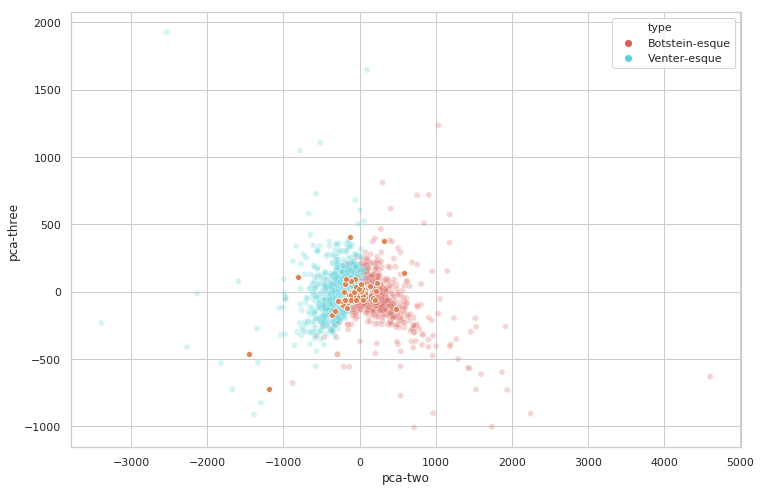

In [492]:
plt.figure()
sns.scatterplot(
    x="pca-two", y="pca-three",
    palette=sns.color_palette("hls",2),
    data=pcadf.loc[pcadf['type']!='Nobel',:],
    legend="full",
    alpha=0.25,
    hue='type'
)

sns.scatterplot(
    x="pca-two", y="pca-three",
    palette=sns.color_palette("hls",1),
    data=pcadf.loc[pcadf['type']=='Nobel',:],
    legend="full",
    alpha=1,
)

In [ ]:
for p in [2,35,55]:
    
    tsne = TSNE(n_components=2, verbose=0, perplexity=p, n_iter=250)
    tsne_results = tsne.fit_transform(pcadf[citation_columns].values)

    pcadf['tsne-2d-one'] = tsne_results[:,0]
    pcadf['tsne-2d-two'] = tsne_results[:,1]

    plt.figure()
    sns.scatterplot(
        x="tsne-2d-one", y="tsne-2d-two",
        hue="type",
        palette=sns.color_palette("hls",2),
        data=pcadf.loc[pcadf['type']!='Nobel'],
        legend="full",
        alpha=0.1
    )
    sns.scatterplot(
        x="tsne-2d-one", y="tsne-2d-two",
        palette=sns.color_palette("hls",pcadf['prizeCategory'].nunique()),
        data=pcadf.loc[pcadf['type']=='Nobel'],
        legend="full",
        hue="prizeCategory",
        alpha=1
    )
    plt.show()

In [514]:
pcadf

,c0,c1,c10,c11,c12,c13,c14,c2,c3,c4,...,c8,c9,pca-one,pca-three,pca-two,prizeCategory,type,tsne-2d-one,tsne-2d-two,alpha
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,-300.742904,16.931348,23.787730,Medicine,Nobel,-3.007440,-3.670126,1.0
34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,-301.153597,16.973488,24.343215,Medicine,Nobel,-3.006220,-3.670484,1.0
62,2.0,2.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,-300.127966,15.403084,23.929417,Physics,Nobel,-3.012838,-3.672473,1.0
79,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,-300.998234,16.778587,24.010538,Literature,Nobel,-3.007913,-3.670781,1.0
83,2.0,3.0,0.0,2.0,6.0,7.0,8.0,2.0,8.0,3.0,...,5.0,2.0,-287.635386,8.756849,23.734820,Physics,Nobel,-3.131405,-3.348606,1.0
91,0.0,3.0,1.0,7.0,9.0,8.0,6.0,2.0,1.0,6.0,...,2.0,5.0,-283.608644,13.266740,24.283694,Medicine,Nobel,-3.181236,-3.203976,1.0
98,0.0,0.0,1.0,3.0,1.0,0.0,0.0,0.0,2.0,0.0,...,3.0,3.0,-296.695479,18.927064,22.680323,Chemistry,Nobel,-3.031591,-3.615034,1.0
103,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,-300.754090,16.115461,24.563999,Physics,Nobel,-3.004569,-3.667639,1.0
124,3.0,3.0,5.0,3.0,3.0,4.0,2.0,3.0,1.0,1.0,...,0.0,11.0,-288.907929,17.518584,21.745074,Physics,Nobel,-3.107024,-3.435408,1.0
137,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,-299.449741,16.834893,23.978758,Physics,Nobel,-3.014411,-3.661031,1.0
